# Vertical Integraion Tutorial for ST and SM Data

This tutorial demonstrates the process of vertically integrating spatial transcriptomics (ST) and spatial metabolomics (SM) data using spatialMETA. 

In [2]:
import spatialmeta as smt
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import copy
import matplotlib.pyplot as plt

## Read and preprocess data

In this section, we read and preprocess the joint SM and ST data. The steps include removing unwanted genes, normalizing the data, identifying spatial variable genes and metabolites, and selecting the subset of spatial variable genes and metaboliyes for further analysis.

In [49]:
joint_adata = sc.read_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_raw.h5ad")

In [50]:
joint_adata = smt.pp.removeHSP_MT_RPL_DNAJ(joint_adata)

In [51]:
joint_adata.layers["counts"] = joint_adata.X.copy()

In [52]:
smt.pp.normalize_total_joint_adata_sm_st(joint_adata,
                         target_sum_SM=1e4,
                         target_sum_ST=1e4)

In [53]:
joint_adata.layers["normalized"] = joint_adata.X.copy()

In [54]:
joint_adata.raw = joint_adata

In [55]:
smt.pp.spatial_variable_joint_adata_sm_st(joint_adata,
                                         n_top_genes = 2000,
                                         n_top_metabolites = 800,
                                         add_key = "highly_variable_moranI")

In [56]:
joint_adata = joint_adata[:,joint_adata.var.highly_variable_moranI]

In [57]:
joint_adata.write_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_hvf2800.h5ad")

## ConditionalVAE model for vertical integration

In this section, the ConditionalVAE model learns a low-dimensional representation of the data that captures the underlying structure and relationships between the SM and ST measurements.

To train the model, we use the `model.ConditionalVAE` class and the `model.fit()` method with the `mode='single'` parameter.

In [34]:
joint_adata = sc.read_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_hvf2800.h5ad")

In [35]:
joint_adata.X = joint_adata.layers["counts"]

In [36]:
smt.pp.normalize_total_joint_adata_sm_st(
    joint_adata,
    target_sum_SM=1e3,
    target_sum_ST=None
)

In [37]:
model = smt.model.ConditionalVAE(
    joint_adata,
    n_latent=10,
    device='cuda:0'
)

In [38]:
loss_dict = model.fit(
    max_epoch=64, 
    lr=1e-3,
    mode='single'
)

Epoch 64: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s, reconst_sm=-1.55e+02, reconst_st=2.75e+02, kldiv=1.17e+


## Loss Visualization

In this section, we visualize the loss during the training of the ConditionalVAE model. The loss consists of three components: Kullback-Leibler divergence loss, reconstruction loss for spatial metabolomics (SM), and reconstruction loss for spatial transcriptomics (ST).

In [39]:
loss_df = pd.DataFrame(loss_dict)

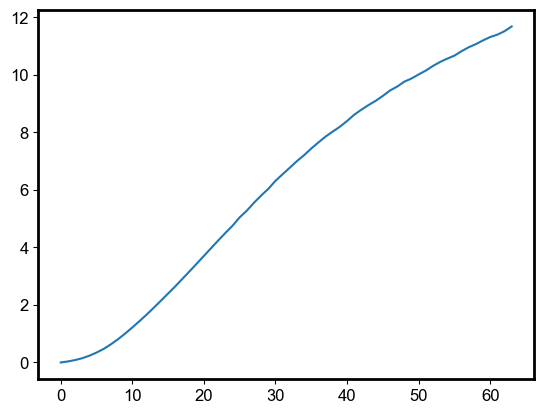

In [40]:
plt.plot(loss_df.index,
         loss_df.epoch_kldiv_loss_list,
         label='epoch_kldiv_loss_list'
)

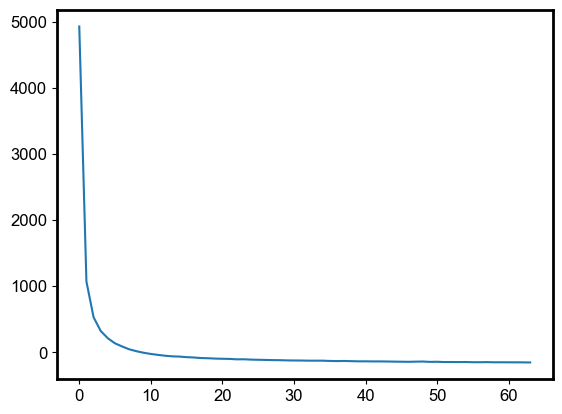

In [41]:
plt.plot(loss_df.index,
         loss_df.epoch_reconstruction_loss_sm_list,
         label='epoch_reconstruction_loss_sm_list'
)

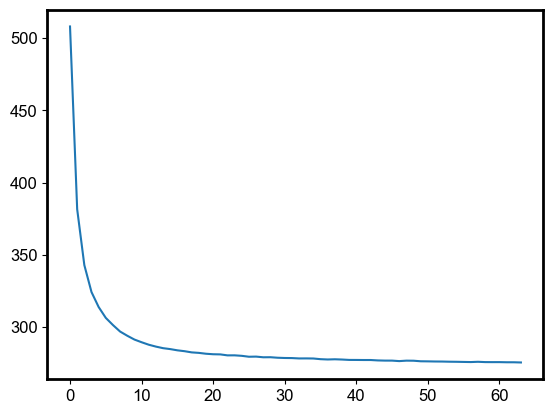

In [42]:
plt.plot(loss_df.index,
         loss_df.epoch_reconstruction_loss_st_list,
         label='epoch_reconstruction_loss_st_list'
) 

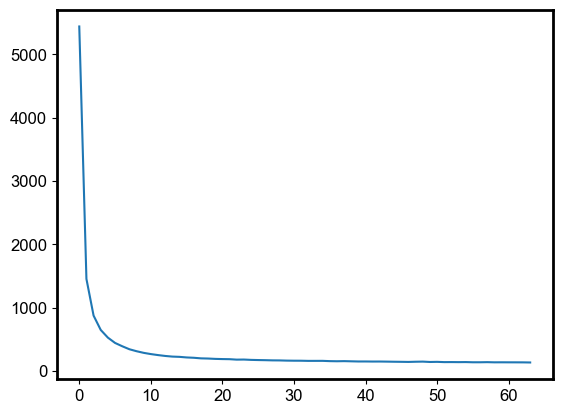

In [43]:
plt.plot(loss_df.index,
         loss_df.epoch_total_loss_list,
         label='epoch_total_loss_list'
) 

## Visualization and analysis

In this section, we visualize the results of the vertical integration using various plots and analysis techniques. We plot the loss curves during model training, visualize the latent space using UMAP, and explore the spatial patterns of specific genes or metabolites after denoising.

In [44]:
Z = model.get_latent_embedding()
X = model.get_normalized_expression()

Latent Embedding: 100%|██████████| 23/23 [00:00<00:00, 70.63it/s]                                                


In [45]:
joint_adata.layers['reconstruction'] = X
joint_adata.obsm['X_emb']=Z

In [46]:
sc.pp.neighbors(
    joint_adata,
    use_rep="X_emb",
    n_neighbors=15
)
sc.tl.umap(
    joint_adata,
    min_dist=1,
    spread=1
)
sc.tl.leiden(
    joint_adata, 
    key_added="VAE_clusters_latent10"
)

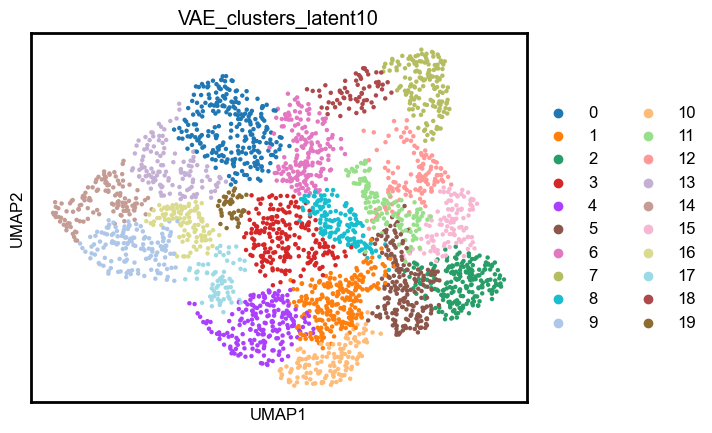

In [59]:
sc.pl.umap(
    joint_adata,
    color=["VAE_clusters_latent10"]
)

[<Axes: title={'center': 'VAE_clusters_latent10'}, xlabel='spatial1', ylabel='spatial2'>]

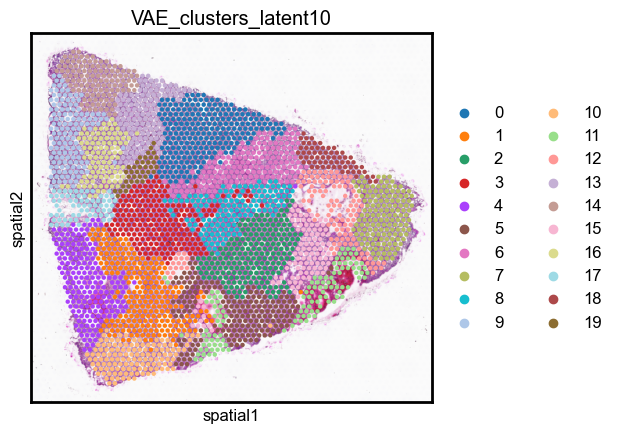

In [60]:
sc.pl.spatial(
    joint_adata, 
    img_key="hires", 
    color=["VAE_clusters_latent10"],
    show=False
)

[<Axes: title={'center': 'CD8A'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': '137.04580812911064'}, xlabel='spatial1', ylabel='spatial2'>]

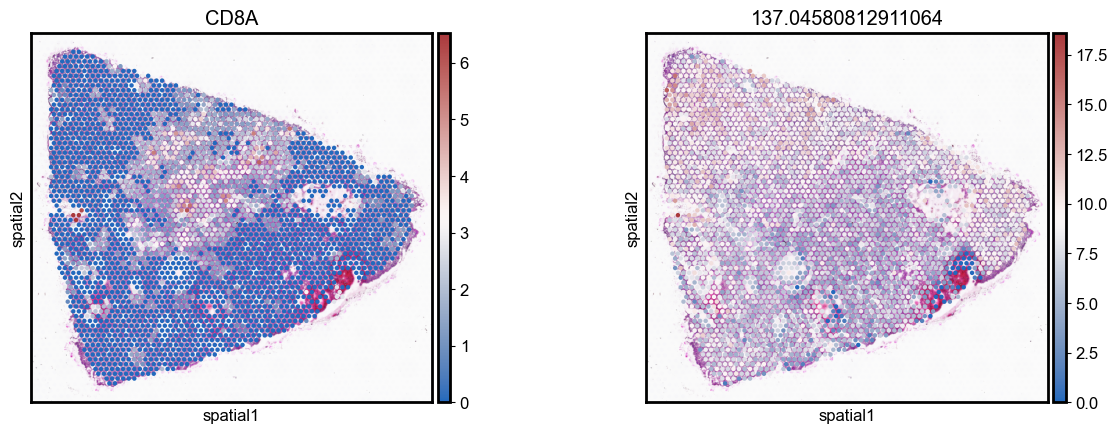

In [61]:
sc.pl.spatial(joint_adata, 
              img_key="hires", 
              color_map = "vlag",
              color=["CD8A","137.04580812911064"],
              layer="normalized",
              show=False)

[<Axes: title={'center': 'CD8A'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': '137.04580812911064'}, xlabel='spatial1', ylabel='spatial2'>]

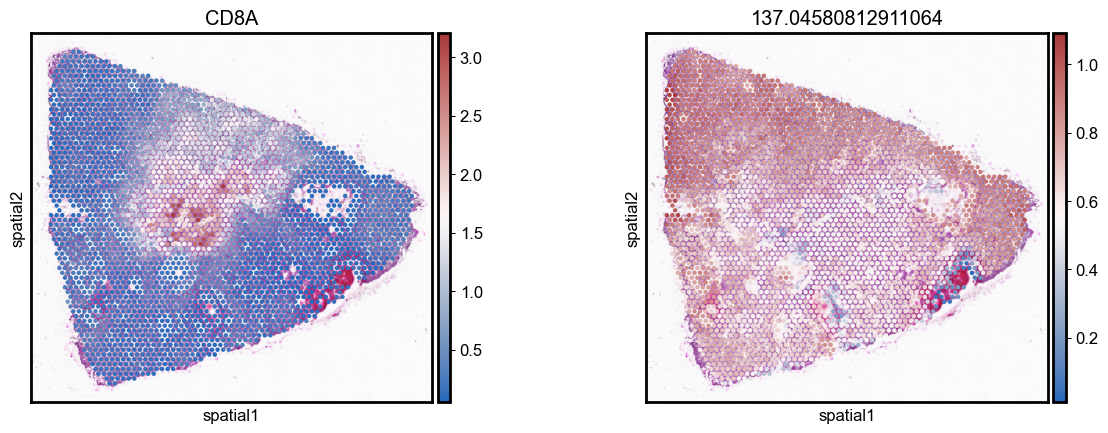

In [62]:
sc.pl.spatial(joint_adata, 
              img_key="hires", 
              color_map = "vlag",
              color=["CD8A","137.04580812911064"],
              layer="reconstruction",
              show=False)

In [ ]:
joint_adata.write_h5ad("./spatialmeta_tutorial/data/Y7_T_adata_joint_hvf2800_afterVAE.h5ad")